In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import display

In [2]:
METAINFO_COLUMNS_COUNT = 0
INPUT_LAYER_SIZE = 64 * 12
WEIGHT_SCALE = 128.0
PRECISE_WEIGHT_SCALE = 64.0

BATCH_SIZE = 32768

In [3]:
cuda = torch.device('cuda')

In [4]:
class CompressedDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, 'rb') as f:
            self.compressed_data = f.read()
        self.record_size = 100
        self.num_samples = len(self.compressed_data) // self.record_size
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        start = idx * self.record_size
        end = start + self.record_size
        record_bytes = self.compressed_data[start:end]
        return record_bytes
    
def collate_fn(batch):
    batch_bytes = np.frombuffer(b''.join(batch), dtype=np.uint8)
    batch_size = len(batch)
    batch_bytes = batch_bytes.reshape(batch_size, -1)
    targets = np.frombuffer(batch_bytes[:, 96:].tobytes(), dtype='<f4')
    features_packed = batch_bytes[:, :96]
    features = np.unpackbits(features_packed, axis=1)
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    return features_tensor, targets_tensor

In [5]:
dataset = CompressedDataset('/home/wind-eagle/Chess/exp/01.qds')
testset = CompressedDataset('/home/wind-eagle/Chess/exp/02.qds')

In [6]:
loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=6,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=collate_fn
    )

test_loader = DataLoader(
        testset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=6,
        prefetch_factor=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=collate_fn
    )

In [7]:
class ClippedReLU(nn.Module):
    def __init__(self, clip_value: float):
        super(ClippedReLU, self).__init__()
        self.clip_value = clip_value

    def forward(self, x):
        return torch.clamp(x.relu(), max=self.clip_value)

In [8]:
class QNNE(nn.Module):
    def __init__(self):
        super(QNNE, self).__init__()

        self.feature = nn.Sequential()
        self.main = nn.Sequential()

        self.feature.add_module('linear', nn.Linear(INPUT_LAYER_SIZE, 256, device=cuda))
        self.feature.add_module('clipped_relu1', ClippedReLU(1.0))

        self.main.add_module('first', nn.Linear(512, 16, device=cuda))
        self.main.add_module('clipped_relu2', ClippedReLU(1.0))

        self.main.add_module('second', nn.Linear(16, 32, device=cuda))
        self.main.add_module('clipped_relu3', ClippedReLU(1.0))

        self.main.add_module('third', nn.Linear(32, 1, device=cuda))
        self.main.add_module('sigmoid', nn.Sigmoid())

        self.xor_indices = np.zeros(INPUT_LAYER_SIZE)
        for i in range(INPUT_LAYER_SIZE):
            self.xor_indices[i] = (i % 64) ^ 56 + (i // 64) * 64

    def forward(self, x):
        return self.main(torch.cat((self.feature(x[:, METAINFO_COLUMNS_COUNT:METAINFO_COLUMNS_COUNT + 64 * 12]),\
                                    self.feature(torch.cat((x[:, METAINFO_COLUMNS_COUNT + 64 * 6:METAINFO_COLUMNS_COUNT + 64 * 12],\
                                    x[:, METAINFO_COLUMNS_COUNT:METAINFO_COLUMNS_COUNT + 64 * 6]), dim=1)[:, self.xor_indices])), dim=1))[:, 0]


In [9]:
def get_loss(model, X, y):
    y = (y + 1.0) / 2
    y_pred = model(X)
    assert y_pred.dim() == 1
    loss = torch.sum((y - y_pred) ** 2) / y_pred.shape[0]
    return loss

In [10]:
plt.rcParams.update({ 'figure.facecolor': 'black', 'axes.facecolor': 'black', 'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white' })

In [11]:
def train_model(model, opt, scheduler, lr_limit):    
    fig = plt.figure()
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)
    train_plot_data_x, train_plot_data_y, test_plot_data_y = [], [], []
    axes.plot(train_plot_data_x, train_plot_data_y)
    fig.canvas.draw()
    hfig.update(fig)

    epoch_num = 0
    with tqdm() as progress:
        while True:
            if opt.param_groups[0]["lr"] + 1e-9 < lr_limit:
                break
            history = []
            test_history = []
            for features, targets in loader:
                features = features.to(cuda, non_blocking=True)
                targets = targets.to(cuda, non_blocking=True)
                loss = get_loss(model, features, targets)

                loss.backward()
                
                opt.step()
                opt.zero_grad()

                with torch.no_grad():
                    model.main.first.weight.data = torch.clamp(model.main.first.weight.data, min=-128.0 / WEIGHT_SCALE, max=127.0 / WEIGHT_SCALE)
                    model.main.second.weight.data = torch.clamp(model.main.second.weight.data, min=-32768.0 / WEIGHT_SCALE / PRECISE_WEIGHT_SCALE, max=32767.0 / WEIGHT_SCALE / PRECISE_WEIGHT_SCALE)

                history.append(loss.data.cpu().numpy())

            for features, targets in test_loader:
                features = features.to(cuda, non_blocking=True)
                targets = targets.to(cuda, non_blocking=True)
                loss = get_loss(model, features, targets)
                test_history.append(loss.data.cpu().numpy())
            
            train_loss = sum(history) / len(history)
            test_loss = sum(test_history) / len(test_history)

            scheduler.step(test_loss)

            train_plot_data_x.append(epoch_num)
            train_plot_data_y.append(train_loss)
            test_plot_data_y.append(test_loss)

            axes.cla()
            axes.plot(train_plot_data_x[-50:], train_plot_data_y[-50:])
            axes.plot(train_plot_data_x[-50:], test_plot_data_y[-50:])
            fig.canvas.draw()
            hfig.update(fig)

            epoch_num += 1
            progress.update(1)
            progress.set_description(f'Average batch loss = {train_loss:.6f}, average test loss = {test_loss:.6f}, lr = {opt.param_groups[0]["lr"]:.6f}')


In [12]:
def print_weights(f, arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            print("{0:0.5f}".format(arr[i][j]), ' ', file=f, sep="", end="")

def print_biases(f, arr):
    for i in range(arr.shape[0]):
            print("{0:0.5f}".format(arr[i]), ' ', file=f, sep="", end="")

def print_model(model, name):
    with open(name, 'w') as f:
        feature_transformer_weights = model.feature.linear.weight.T.detach().cpu().numpy()
        feature_transformer_biases = model.feature.linear.bias.detach().cpu().numpy()
        print_weights(f, feature_transformer_weights)
        print_biases(f, feature_transformer_biases)
        print_weights(f, model.main.first.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.first.bias.detach().cpu().numpy())
        print_weights(f, model.main.second.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.second.bias.detach().cpu().numpy())
        print_weights(f, model.main.third.weight.T.detach().cpu().numpy())
        print_biases(f, model.main.third.bias.detach().cpu().numpy())

In [13]:
import gc
gc.collect()
model = QNNE()

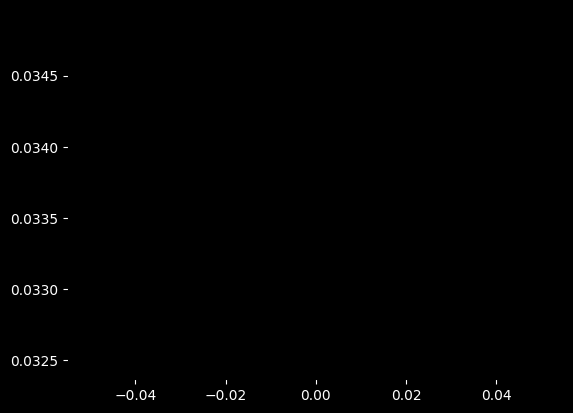

Average batch loss = 0.034845, average test loss = 0.032486, lr = 0.010000: : 1it [01:32, 92.79s/it]


KeyboardInterrupt: 

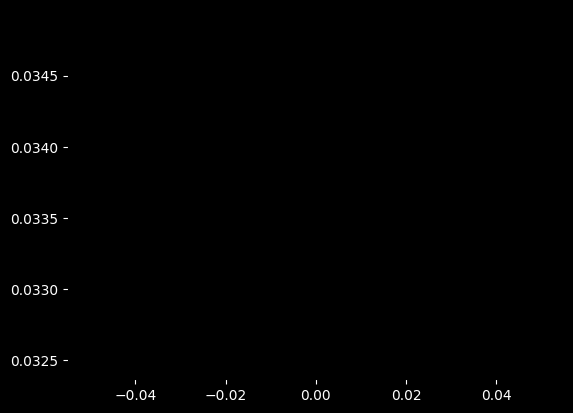

In [14]:
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=7e-6)
scheduler = ReduceLROnPlateau(opt, patience=20, factor=np.cbrt(0.1))
train_model(model, opt, scheduler, 0.0001)

In [ ]:
print_model(model, 'model.qnne')